In [1]:
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import scipy as sc

# graficos incrustados
%matplotlib inline


In [2]:
# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [3]:
data=pd.read_csv('winequality-red.csv')

# 1- Descripción del dataset.

<font color=blue>
El objetivo de este conjunto de datos es predecir la calidad del vino (en base a  preferencias de sabor) a partir de datos obtenidos en pruebas analíticas. Esto puede lograrse mediante tareas de regresión o clasificación utilizando una gran variedad de modelos y algoritmos, como redes neuronales, máquinas de soporte vectorial, modelos de regresión multiple etc..
Estos modelos serán útiles para apoyar las evaluaciones de cata de vinos de enólogos y mejorar la producción de vino. Además, técnicas similares pueden ayudar en el marketing objetivo al modelar los gustos de los consumidores en los mercados especializados.



<font color=blue>
El conjuntos de datos se refiere a las variantes tinto del vino portugués "Vinho Verde". Debido a cuestiones de privacidad y logística, solo están disponibles las variables fisicoquímicas (entradas) y sensoriales (salida) (por ejemplo, no hay datos sobre tipos de uva, marca de vino, precio de venta del vino, etc.).
Las clases están ordenadas y no equilibradas (por ejemplo, hay vinos mucho más normales que excelentes o malos).


<font color=blue>
Variables de entrada (basadas en pruebas fisicoquímicas):
1 - acidez fija
2 - acidez volátil
3 - ácido cítrico
4 - azúcar residual
5 - cloruros
6 - dióxido de azufre libre
7 - dióxido de azufre total
8 - densidad
9 - pH
10 - sulfatos
11 - alcohol
Variable de salida (basada en datos sensoriales):
12 - calidad (puntuación entre 0 y 10)


In [4]:
data.head().round(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5


In [5]:
# Analizamos los estadísticos de las variables explicativas
data.describe().round(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


#2 -Integración y selección de los datos de interés a analizar.

<font color=blue>
Los datos disponibles se encuentran todos en el dataset proporcionado por Kaggel. No se requieren integraciones con otros conjuntos de datos.
En cuanto a la variable de estudio (“quality”) vamos a realizar diversas codificaciones que nos permitan trabajar con ella en modelos de deep learning (one hot encoding) así como en modelos de clasificación binaria. Para ello vamos a seguir la sugerencia de establecer un límite arbitrario para su variable dependiente (calidad del vino) en, por ejemplo, 7 o superior obteniendo la clasificación como 'buena / 1' y el resto como 'no buena / 0'.



In [6]:
# Preprocesado en dos categorias
data['target'] = np.where(data['quality'] > 6.5, 'Alta', 'Baja')
data['y'] = np.where(data['target'] == 'Baja', 0 ,1)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Baja,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Baja,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Baja,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Baja,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Baja,0


In [7]:
variables_independientes=list(data.columns)[:-3]

### Procesamiento para algoritmos de deep learning

Vamos a codificar la variable dependiente en un formato que sirva para utilizar los datos en algoritmos de clasificación múltiple.

In [8]:
#One hot encoding
quality_one_hot=pd.get_dummies(data['quality'],prefix='quality')
dataOneHot = pd.concat([data[variables_independientes],quality_one_hot] , axis=1)
dataOneHot.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0,1,0,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0,1,0,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0,0,1,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0


# 3 - Limpieza y preprocesado de datos.

<font color=blue>
En este apartado vamos a analizar los datos vacíos y los datos atípicos del dataset para  establecer una estrategia para su tratamiento de forma que no afecten al resultado de los modelos.
Mediante un análisis visual revisaremos los datos atípicos de cada una de las variables explicativas por separado. Posteriormente analizaremos la correlación entre las variables explicativas y finalmente haremos un análisis multivariante de los outliers. Para ello utilizaremos la distancia de Mahalanobis que tiene en cuenta esta correlación. Finalmente realizaremos una normalización de los datos por si se pretenden utilizar algoritmos sensibles a la escala como son los PCAs o las redes neuronales.



##3.1. Datos vacíos

In [9]:
# Buscamos valores nulos
data.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
target                  False
y                       False
dtype: bool

<font color=blue>
No hay valores nulos en el conjunto de datos.

In [10]:
data[variables_independientes].corr().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06
volatile acidity,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20
citric acid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11
residual sugar,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04
chlorides,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22
free sulfur dioxide,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07
total sulfur dioxide,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21
density,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21
sulphates,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09


<font color=blue> 
De la matriz de correlación anterior, podemos observar que existe una correlación positiva relativamente alta entre Fixed_acidity y Citric_acid, Fixed_acidity y Densidad. 
De manera similar, podemos observar que existe una correlación negativa relativamente alta entre la acidez fija y el pH.
A pesar de la existencia de estas correlaciones, estas no son extremadamente altas, por lo que con la eliminación de alguna variable, estariamos perdiendo información valiosa.


##3.2. Identificación y tratamiento de valores extremos.

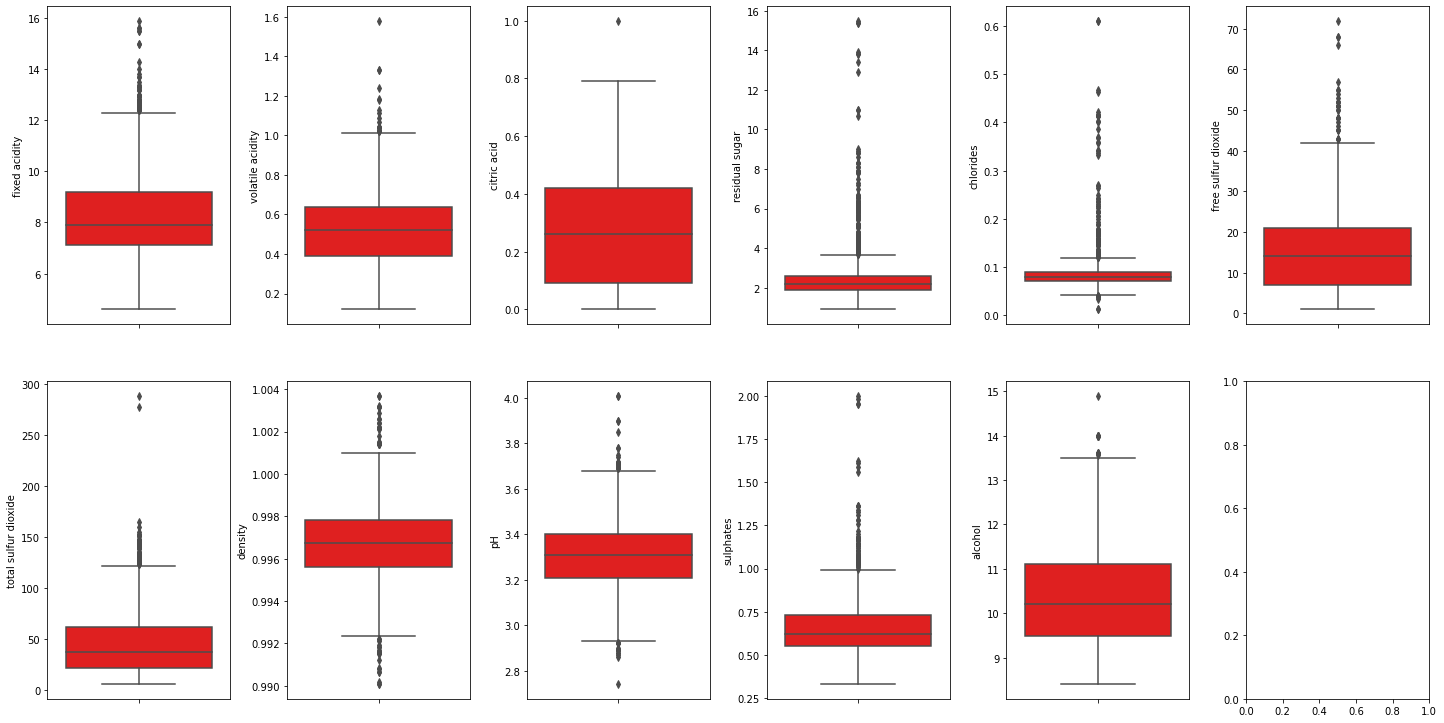

In [11]:
#Analizamos visualmente los outliers mediante box plots
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
df=data[variables_independientes]
for col, value in df.items():
    sns.boxplot(y=col, data=df, color='r', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

<font color=blue>
Nos encontramos ante un conjunto de datos con variables correlacionadas y un gran número de datos atípicos por lo que vamos a detectar y eliminar los outliers utilizando la distancia de Mahalanobis, que tiene en cuenta las distintas escalas de las variables y su correlación. Finalmente eliminaremos del conjunto de datos todas aquellas observaciones cuya distancia sea superior a 3 veces la desviación típica conjunta.

In [12]:
# Utilizaremos el codigo descrito en: https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance/51894355 
def MahalanobisDist(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")

In [13]:
def MD_detectOutliers(data, extreme=False):
    MD = MahalanobisDist(data)
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [14]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [15]:
# Detectamos los outliers con la función anterior
outliers_indices = MD_detectOutliers(np.array(data[variables_independientes]))
outliers_indices


array([  13,   17,   19,   33,   42,   81,   83,   86,   91,   92,  106,
        151,  169,  226,  243,  244,  258,  281,  291,  324,  325,  353,
        396,  400,  451,  480,  553,  559,  564,  614,  649,  651,  652,
        672,  692,  723,  730,  754,  861, 1017, 1018, 1051, 1079, 1081,
       1165, 1235, 1244, 1260, 1299, 1316, 1319, 1321, 1370, 1372, 1434,
       1435, 1474, 1476, 1558, 1574])

In [16]:
# Eliminamos los outliers y visualizamos los principales estadísticos del nuevo conjunto de datos.
data_inliers=data.drop(outliers_indices,axis=0)
data_inliers.describe().round(3)

# Los eliminamos también del conjunto de datos formateados en one hot
data_inliers_one_hot=dataOneHot.drop(outliers_indices,axis=0)

<font color=blue>
Hemos eliminado 60 observaciones, por lo que la perdida de datos no es significativa con respecto al tamaño total del data set, y en cambio, hemos ganado centralidad en los datos eliminando los valores extremos.

##3.3. Normalización de los datos

<font color=blue>
Llevamos a cabo una normalización de los datos. Esta normalización es necesaria para poder utilizar este conjunto de datos en algoritmos sensibles a la escala, como PCAs o redes neuronales, por tanto, dicha normalización la llevamos a cabo con los datos con formato one hot.

In [17]:
# Normalización o estandarización
from sklearn.preprocessing import StandardScaler


data_nor_one_hot=StandardScaler().fit_transform(data_inliers_one_hot[variables_independientes])
data_nor_one_hot=pd.DataFrame(data_nor_one_hot,columns=variables_independientes)
data_nor_one_hot.describe().round(5)

# Además, normalizamos los datos en formato estandar.

data_nor=StandardScaler().fit_transform(data_inliers[variables_independientes])
data_nor=pd.DataFrame(data_nor,columns=variables_independientes)
data_nor.describe().round(5)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000,1539.00000
mean,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000
std,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033
min,-2.16355,-2.32269,-1.38705,-1.22202,-2.82520,-1.46068,-1.26256,-3.57724,-3.10592,-2.28355,-1.93387
25%,-0.70351,-0.78339,-0.91616,-0.53733,-0.50303,-0.85902,-0.74622,-0.61257,-0.65655,-0.69826,-0.88659
50%,-0.23630,-0.04225,-0.07904,-0.24390,-0.14269,-0.25737,-0.26215,-0.00866,-0.04421,-0.19384,-0.22014
75%,0.52292,0.64188,0.81040,0.14735,0.25768,0.54484,0.48008,0.59525,0.56813,0.52675,0.63673
max,4.26061,4.57565,2.58929,6.40737,7.50445,4.15477,3.86857,3.55992,3.97004,5.13852,3.39774


<font color=blue>
Podemos comprobar que ahora todas las variables se distribuyen conforme a una distribución normal de media 0 y varianza 1

#4 - Análisis de los datos.

<font color=blue>
Una vez identificadas estas variables, analizaremos si su distribución se ajusta a una distribución normal. Posteriormente estableceremos un grupo con los vinos de buena calidad y otro con los de calidad baja y analizaremos visualmente si su distribución es diferente. Este análisis visual lo certificaremos posteriormente con un test para la diferencia de medias en poblaciones independientes. También realizaremos un test que asegure que la varianza es constante en ambos grupos.


<font color=blue>
Finalmente vamos a efectuar una seleccion de las variables que vamos a utilizar en los modelos mediante dos metodos de selección de atributos. Algoritmos de filtro o univariantes, y algoritmos empotrados, que tienen en cuenta el clasificador que se utilizará para resolver el problema.




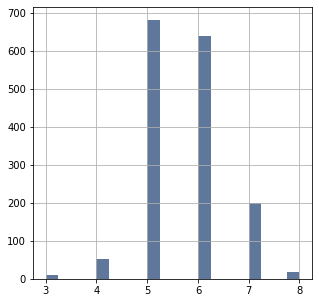

In [18]:
# Distribución de la variable dependiente
data['quality'].hist(bins=20,figsize=(5,5))
plt.show()

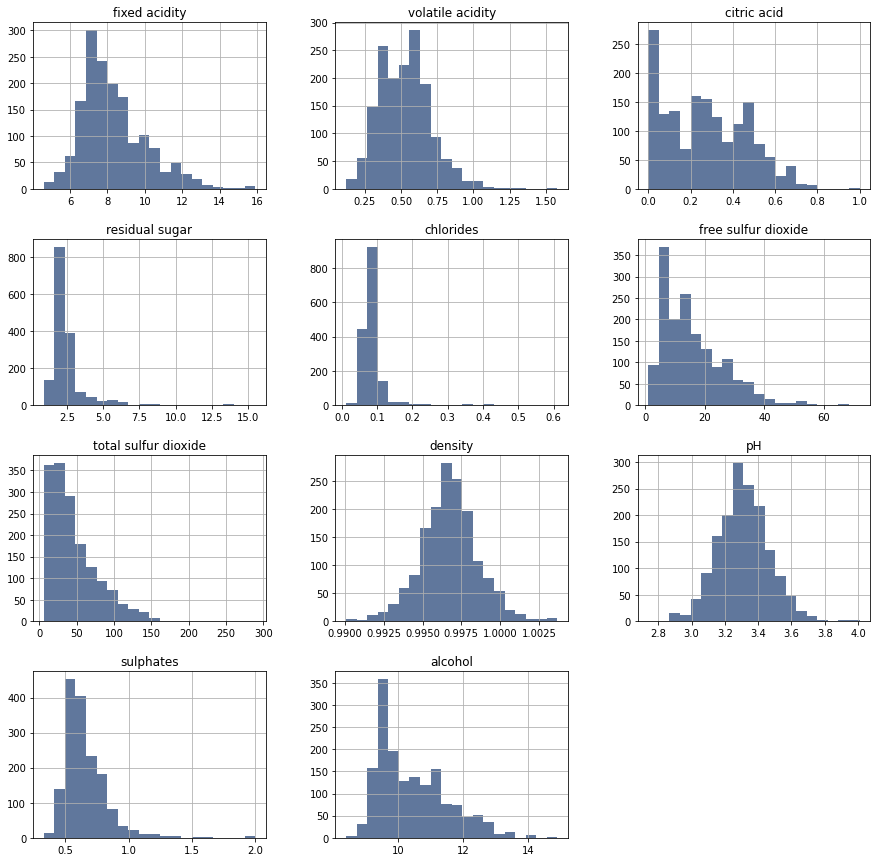

In [19]:
#variables_independientes=list(data.columns)[:-2]
# Analisis visual univariante.
data[variables_independientes].hist(bins=20,figsize=(15, 15))
plt.show()

##4.1. Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar).

<font color=blue>
Vamos a analizar la correlación de las variables independientes con la variable dependiente.

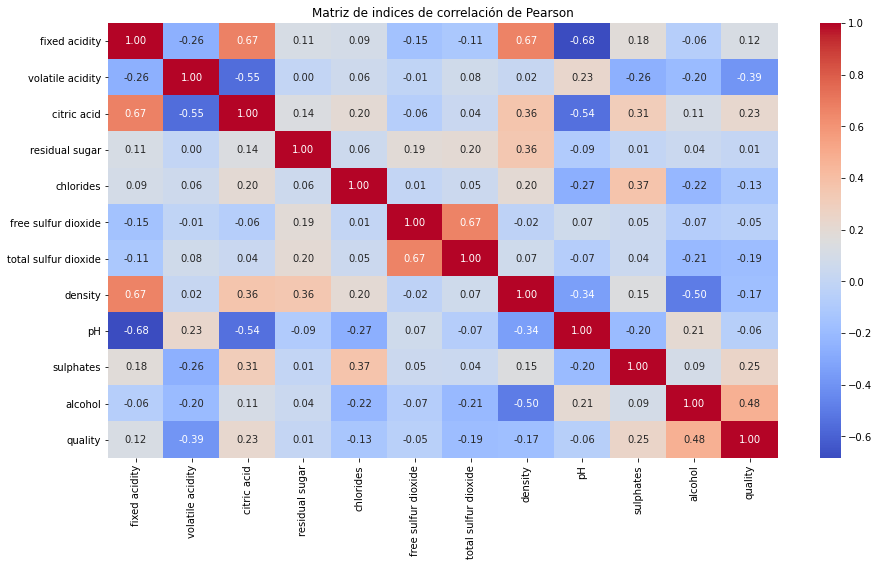

In [20]:
# Indice de correlación de pearsons
correlation_mat = data[data.columns[:-1]].corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Matriz de indices de correlación de Pearson')
plt.show()

In [21]:
# De la matriz de correlación, analizamos la correlación con la variable de estudio 
p = abs(correlation_mat.quality)
p.sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

<font color=blue>
Vemos por tanto, que la variable independiente con una mayor correlación con la variable dependiente es la cantidad de alcohol, seguido por la volatilidad de la acidez. Por otro lado, el azúcar residual, el sulfuro de dioxido libre y el pH, tiene una correlación muy baja con la calidad del vino.

In [22]:
a=data[data.columns[:-1]]
sns.pairplot(a, hue="quality", height=2, palette=sns.color_palette("husl", 6), diag_kind='hist')


Output hidden; open in https://colab.research.google.com to view.

<font color=blue>
Gracias a este conjunto de graficos se puede realizar un estudio más preciso. Para el caso del alcohol, se puede observar que hay una partición entre los vinos de baja calidad y de alta, partición relacionada con la cantidad de alcohol. Como mayor es la cantidad de alcohol, mayor es la calidad (en lineas generales).
Anteriormente habiamos observado que habia una alta correlación entre las variables fixed acidity y pH. Sin embargo, esta correlación es independiente de la calidad por lo que podemos observar en estos graficos, a la vez que en cambio, podemos ver que hay una cierta partición en la columna de los sulfatos, obervación que no habiamos podido hacer con antelación.

##4.2. Comprobación de la normalidad y homogeneidad de la varianza.

<font color=blue>
Analizamos la normalidad y homogeneidad de la varianza para el conjunto de variables idependientes

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


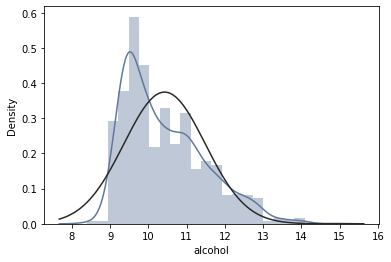

In [30]:
from scipy.stats import norm

sns.distplot(data['alcohol'], fit = norm)


In [31]:
#Test de Shapiro–Wilk The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
shp_test=sc.stats.shapiro(data['alcohol'])
shp_test

(0.9288389682769775, 6.643664824998876e-27)

<font color=blue>
El test de Saphiro-Wilk plantea como hipótesis nula el hecho que la muestra siga una distribución normal. Dicha hipótesis se rechaza cuando el valor del estadístico (W) es muy pequeño. Dicho valor oscila entre 0 y 1. Con estos resultados (W=0.93) no podemos rechazar la hipotesis nula y por tanto no hay evidencia de que la variable no se distribuya normalmente. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


resultador del test: (0.9743340611457825, 2.686806772838566e-16)


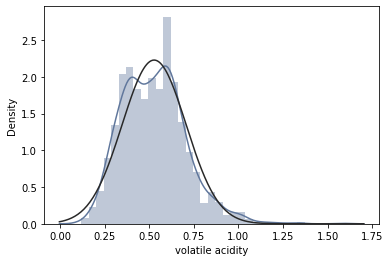

In [34]:
sns.distplot(data['volatile acidity'], fit = norm)

shp_test=sc.stats.shapiro(data['volatile acidity'])
print("resultador del test: " + str(shp_test))

<font color=blue>
De nuevo, no podemos rechazar la hipótesis nula con W=0.97.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


resultador del test: (0.8330425024032593, 5.821617678881608e-38)


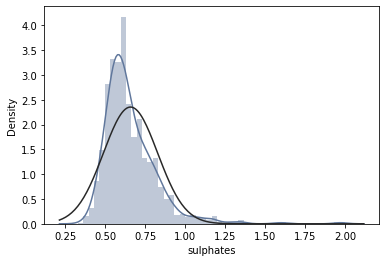

In [35]:
sns.distplot(data['sulphates'], fit = norm)

shp_test=sc.stats.shapiro(data['sulphates'])
print("resultador del test: " + str(shp_test))

<font color=blue>
Lo mismo ocurre para los sulfatos, con W=0.83. Hemos visto por tanto, que las variables con una mayor correlación con la calidad, siguen una distribución normal.

El supuesto de homogeneidad de varianzas, también conocido como supuesto de homocedasticidad, considera que la varianza es constante (no varía) en los diferentes niveles de un factor, es decir, entre diferentes grupos. En el siguiente apartado se realiza el estudio.



##4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos.

In [37]:
alcohol_0=data[data.target=='Baja']['alcohol']
alcohol_1=data[data.target=='Alta']['alcohol']

In [38]:
alcohol_0.describe()

count    1382.000000
mean       10.251037
std         0.969664
min         8.400000
25%         9.500000
50%        10.000000
75%        10.900000
max        14.900000
Name: alcohol, dtype: float64

In [39]:
alcohol_1.describe()

count    217.000000
mean      11.518049
std        0.998153
min        9.200000
25%       10.800000
50%       11.600000
75%       12.200000
max       14.000000
Name: alcohol, dtype: float64

In [40]:
#La hipótesis nula es que los datos proceden de distribuciones con la misma varianza (homocedasticidad)
levene_test = sc.stats.levene(alcohol_0, alcohol_1, center='median')
levene_test

LeveneResult(statistic=1.4506052991623122, pvalue=0.2286093177882187)

<font color=blue>
No podemos rechazar la hipotesis nula con un nivel de significacion del 0.05 %, así pues, ambos grupos provienen de distribuciones con la misma varianza. Para dividir en dos grupos los otros atributos deberiamos seguir procedimientos similares, obteniendo grupos con similares características, o en su defecto, grupos con resultados aleatorios para este test, lo cual no aporta información valiosa para el estudio. 

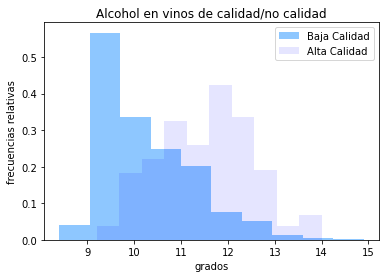

In [42]:
alcohol_0=data[data.target=='Baja']['alcohol']
alcohol_1=data[data.target=='Alta']['alcohol']
plt.hist(alcohol_0, density=1, facecolor='dodgerblue', alpha=0.5,label='Baja Calidad')
plt.hist(alcohol_1, density=1, facecolor='blue', alpha=0.1,label='Alta Calidad')
plt.ylabel("frecuencias relativas")
plt.title("Alcohol en vinos de calidad/no calidad")
plt.xlabel("grados")
plt.legend()



<font color=blue>
Test de comparación de dos medias muestrales con identicas varianzas




In [43]:
sc.stats.ttest_ind(alcohol_0,alcohol_1)

Ttest_indResult(statistic=-17.822763607394528, pvalue=6.016774226316707e-65)

<font color=blue>
Con p-valor prácticamente 0, rechazamos la hipótesis nula de igual de medias.

En el apartado 5, realizamos el estudio de regresión logística.

###4.3.1. Selección de atributos univariante

Este algoritmo selecciona a los mejores atributos basándose en una prueba estadística univariante.

In [44]:
# https://relopezbriega.github.io/blog/2016/04/15/ejemplo-de-machine-learning-con-python-seleccion-de-atributos/
from sklearn.feature_selection import SelectKBest, chi2,f_classif
X=data[variables_independientes]
y=data['quality']
seleccionadas = SelectKBest(f_classif, k=5).fit(X, y)
atrib=seleccionadas.get_support()
atributos=[variables_independientes[i] for i in list(atrib.nonzero()[0])]
atributos

['volatile acidity',
 'citric acid',
 'total sulfur dioxide',
 'sulphates',
 'alcohol']

<BarContainer object of 11 artists>

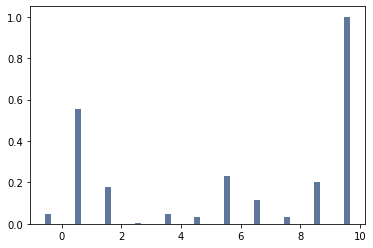

In [45]:
from sklearn.feature_selection import SelectKBest,f_classif,RFE
X=data[variables_independientes]
y=data['quality']
seleccionadas = SelectKBest(f_classif, k=3).fit(X, y)

# visualizar el logaritmo del p-valor del test 
X_indices = np.arange(X.shape[-1])
scores = -np.log10(seleccionadas.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

In [46]:
# Visualizar las variables seleccionadas
atrib=seleccionadas.get_support()
atributos=[variables_independientes[i] for i in list(atrib.nonzero()[0])]
atributos

['volatile acidity', 'total sulfur dioxide', 'alcohol']

###4.3.2. Selección de atributos multivariante

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()
era = RFE(modelo, n_features_to_select=5)  # número de atributos a seleccionar
era = era.fit(X,y)
atrib = era.support_
atributos2=[variables_independientes[i] for i in list(atrib.nonzero()[0])]
atributos2


['volatile acidity', 'density', 'pH', 'sulphates', 'alcohol']

#5 - Representación de los resultados a partir de tablas y gráficas.

<font color=blue>
Una vez seleccionados los atributos que aportan información para la resolución del problema, vamos a ejecutar una clasificación mediante un modelo de regresión logistica y a presentar los resultados

Regresión logística con la selección de atributos univariante

In [54]:
# Preparamos los datos para regresion Logistica. Tomamos los datos estandarizados sin outliers

X=data_nor[atributos]
y=data_inliers['y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [55]:
# Realizamos la clasificación y presentamos los resultados
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model=LogisticRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("classification report\n")
print(classification_report(y_test,y_pred))
print("\nConfusion matrix: \n")
print(confusion_matrix(y_test,y_pred))
print("\n")
print("{} model has accuracy of {}".format(str(model),accuracy_score(y_test, y_pred)))

Accuracy score: 0.8838582677165354
classification report

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       437
           1       0.75      0.25      0.38        71

    accuracy                           0.88       508
   macro avg       0.82      0.62      0.66       508
weighted avg       0.87      0.88      0.86       508


Confusion matrix: 

[[431   6]
 [ 53  18]]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) model has accuracy of 0.8838582677165354


Regresión logística con la selección de atributos multivariante

In [56]:
# Preparamos los datos para regresion Logistica. Tomamos los datos estandarizados sin outliers

X=data_nor[atributos2]
y=data_inliers['y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [57]:
# Realizamos la clasificación y presentamos los resultados

model=LogisticRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("classification report\n")
print(classification_report(y_test,y_pred))
print("\nConfusion matrix: \n")
print(confusion_matrix(y_test,y_pred))
print("\n")
print("{} model has accuracy of {}".format(str(model),accuracy_score(y_test, y_pred)))

Accuracy score: 0.8858267716535433
classification report

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       437
           1       0.74      0.28      0.41        71

    accuracy                           0.89       508
   macro avg       0.82      0.63      0.67       508
weighted avg       0.87      0.89      0.86       508


Confusion matrix: 

[[430   7]
 [ 51  20]]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) model has accuracy of 0.8858267716535433


<font color=blue>
Podemos observar que los resultados son muy similares para ambas regresiones, con muy pocas diferencias a pesar de utilizar distintos atributos tanto para el entrenamiento como para la predicción. 

A continuación, vamos a utilizar una pequeña red neuronal para hacer clasificación con este data set. Utilizaremos la totalidad de las variables (11) y el formato de etiquetas one hot encoding. Por tanto, la predicción será una de las 5 posibles calidades de vino, en lugar de únicamente bueno, o malo, como tenemos con la regresión.

In [63]:

from keras.models import Sequential
from keras.layers.core import Dense


#Creacion de los train y test data sets con one-hot encoding:
X_one_hot=data_nor_one_hot
y_one_hot=data_inliers_one_hot[['quality_3','quality_4','quality_5','quality_6','quality_7','quality_8']]
X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(X_one_hot,y_one_hot, test_size=0.33, random_state=42)


model = Sequential()
model.add(Dense(16, input_dim=11, activation='relu'))
model.add(Dense(6, activation='softmax'))

 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
 
model.fit(X_train_one_hot, y_train_one_hot, epochs=100)

Epoch 1/100
33/33 [==============================] - 1s 1ms/step - loss: 1.7015 - binary_accuracy: 0.8263
Epoch 2/100
33/33 [==============================] - 0s 1ms/step - loss: 1.4820 - binary_accuracy: 0.8283
Epoch 3/100
33/33 [==============================] - 0s 1ms/step - loss: 1.3631 - binary_accuracy: 0.8312
Epoch 4/100
33/33 [==============================] - 0s 1ms/step - loss: 1.2043 - binary_accuracy: 0.8456
Epoch 5/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1574 - binary_accuracy: 0.8518
Epoch 6/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1244 - binary_accuracy: 0.8567
Epoch 7/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1061 - binary_accuracy: 0.8494
Epoch 8/100
33/33 [==============================] - 0s 1ms/step - loss: 1.0606 - binary_accuracy: 0.8611
Epoch 9/100
33/33 [==============================] - 0s 1ms/step - loss: 1.0319 - binary_accuracy: 0.8614
Epoch 10/100
33/33 [==========================

In [64]:

test_loss, test_acc = model.evaluate(X_test_one_hot, y_test_one_hot, verbose=2)
print('\nTest accuracy:', test_acc)

16/16 - 0s - loss: 0.9476 - binary_accuracy: 0.8652

Test accuracy: 0.8651575446128845


<font color=blue>
Una vez entrenado y evaluado el modelo, vemos que este cuenta con una precisión del 86% para la predicción de la calidad del vino. Esto es únicamente un 2% menos de la precisión que teniamos con el modelo logístico de regresión para la clasificación entre bueno y malo.

#6 - Resolución del problema.

A partir de los resultados obtenidos, ¿cuáles son las
conclusiones? ¿Los resultados permiten responder al problema?

Durante la realización de esta práctica, hemos realizado distintos análisis sobre la base de datos, con el objetivo de entender mejor que relaciones hay entre las variables independientes, y la calidad del vino. Hemos limpiado los datos de posibles entradas que puedieran desviar los resultados. Hemos analizado también las relaciones entre las distintas variables independientes, y finalmente, hemos preparado los datos para poder aplicarlos en algoritmos de predicción/clasificación, tanto binaria como múltiple, que era el objetivo final de la práctica. 

Hemos conseguido crear un modelo que predice con precisión superior al 85% no solo si la calidad del vino es buena o mala (modelos de clasificación binaria), sino la valoración concreta de cada uno de los vinos. 

Por lo que se puede afirmar que se han alcanzado los objetivos y que el data set tiene calidad suficiente para la creación de los modelos. A partir de estos modelos, se puede predecir la valoración de un nuevo vino, por lo que se podrían definir distintas estrategias comerciales con nuevos vinos, como por ejemplo, fijación de precios para nuevos vinos lanzados al mercado, o campañas de marketing. 